## XAI mini project- (AIFB dataset) Strategy 2 : Using a XGBOOST Classifier and LIME to explain the predictions

# Setup and Imports

In [1]:
import random
import time
import pandas as pd
import rdflib as rdf
import time
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd

In [2]:
train_file = 'data/trainingSet.tsv'
test_file = 'data/testSet.tsv'

# Data Loading

In [20]:
# warnings.filterwarnings("ignore")

graph_path = "data/aifbfixed_complete.n3"
graph = rdf.Graph()
graph.parse(graph_path, format="n3")
print("Triples Loaded:", len(graph))

Triples Loaded: 29226


In [21]:

data = {}

for s, p, o in graph:
    if str(s) not in data:
        data[str(s)] = {}
    data[str(s)][p] = str(o)

df = pd.DataFrame.from_dict(data, orient='index')

df = df.fillna('')
df.index = df.index.astype(str)
len(df)

2829

In [22]:
pd.set_option('display.max_rows', 50)

In [23]:
df.columns = df.columns.str.split("/").str[-1]
df.columns = df.columns.str.split("#").str[-1]

df = df.apply(lambda col: col.map(lambda x: x.split("/")[-1]))
df = df.apply(lambda col: col.map(lambda x: x.split("#")[-1]))


In [24]:
df.head()

,editor,isbn,month,type,title,year,hasProject,volume,series,isAbout,author,booktitle,pages,abstract,projectInfo,member,name,homepage,financedBy,carriedOutBy,type,journal,number,publishes,carriesOut,employs,head,publication,worksAtProject,affiliation,photo,fax,phone,note,address,howpublished,dealtWithIn,isWorkedOnBy,type,onProperty,allValuesFrom,edition,subClassOf,chapter,inverseOf,finances,range
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id965instance,id613instance,1-58603-523-1,July,Book,"Ontology Learning from Text: Methods, Evaluati...",2005,id50instance,123,Frontiers in Artificial Intelligence,id71instance,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id837instance,id518instance,,April,Publication,Applications of Evolutinary Computing,2004,,3005,LNCS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id954instance,id604instance,,,Publication,EMISA 2004 - Informationssysteme im E-Business...,2004,,P-56,LNI,,,,,,,,,,,,,,,,,,,,,,,,,,Bonn,,,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1336instance,id840instance,,November,Publication,Proceedings of the Second Workshop OWL - Exper...,2006,id42instance,216,CEUR Workshop Proceedings,id58instance,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id284instance,id57instance,,,Book,Handbook on Ontologies,2004,,,,id69instance,,,,,,,,,,,,,,,,,,,,,,,,,Heidelberg,,,,,,,,,,,,


# Data Exploration

In [25]:
df.columns

Index(['editor', 'isbn', 'month', 'type', 'title', 'year', 'hasProject',
       'volume', 'series', 'isAbout', 'author', 'booktitle', 'pages',
       'abstract', 'projectInfo', 'member', 'name', 'homepage', 'financedBy',
       'carriedOutBy', 'type', 'journal', 'number', 'publishes', 'carriesOut',
       'employs', 'head', 'publication', 'worksAtProject', 'affiliation',
       'photo', 'fax', 'phone', 'note', 'address', 'howpublished',
       'dealtWithIn', 'isWorkedOnBy', 'type', 'onProperty', 'allValuesFrom',
       'edition', 'subClassOf', 'chapter', 'inverseOf', 'finances', 'range'],
      dtype='object')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2829 entries, http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id965instance to http://swrc.ontoware.org/ontology#series
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   editor          2829 non-null   object
 1   isbn            2829 non-null   object
 2   month           2829 non-null   object
 3   type            2829 non-null   object
 4   title           2829 non-null   object
 5   year            2829 non-null   object
 6   hasProject      2829 non-null   object
 7   volume          2829 non-null   object
 8   series          2829 non-null   object
 9   isAbout         2829 non-null   object
 10  author          2829 non-null   object
 11  booktitle       2829 non-null   object
 12  pages           2829 non-null   object
 13  abstract        2829 non-null   object
 14  projectInfo     2829 non-null   object
 15  member          2829 non-null  

In [27]:
df['affiliation'].value_counts()

affiliation
               2651
id1instance      73
id3instance      60
id2instance      28
id4instance      16
id5instance       1
Name: count, dtype: int64

In [45]:
df.index.unique()

Index(['http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id965instance',
       'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id837instance',
       'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id954instance',
       'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1336instance',
       'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id284instance',
       'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1251instance',
       'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id945instance',
       'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id1005instance',
       'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id949instance',
       'http://www.aifb.uni-karlsruhe.de/Publikationen/viewPublikationOWL/id702instance',
       ...
       'http://swrc.ontoware.org/ontology#phone',
       'http://swrc.ontoware.org/ont

As we only need the persons data, we validated by only selecting persons from train and test files.

# Feature Selection using Variance threshold

In [ ]:
train_labels_df = pd.read_csv("data/trainingSet.tsv", sep="\t")
test_labels_df = pd.read_csv("data/testSet.tsv", sep="\t")

#only valid persons
train_labels_df['person'] = train_labels_df['person'].astype(str).str.strip()
test_labels_df['person'] = test_labels_df['person'].astype(str).str.strip()


df.index = df.index.astype(str).str.strip()


df_encoded = pd.get_dummies(df)

train_matches = df_encoded.index.intersection(train_labels_df['person'])
test_matches = df_encoded.index.intersection(test_labels_df['person'])

print(f"Matched training persons: {len(train_matches)}")
print(f"Matched testing persons: {len(test_matches)}")

# x labels
X_train = df_encoded.loc[train_matches]
X_test = df_encoded.loc[test_matches]

# y labels
y_train = train_labels_df.set_index('person').loc[train_matches]['label_affiliation']
y_test = test_labels_df.set_index('person').loc[test_matches]['label_affiliation']


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Matched training persons: 140
Matched testing persons: 36
X_train shape: (140, 6884)
X_test shape: (36, 6884)
y_train shape: (140,)
y_test shape: (36,)


In [29]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.001)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)

# initially selected feature names
initial_feature_names = df_encoded.columns[selector.get_support(indices=True)]

# features to exclude manually
excluded_features = {
    'affiliation_id1instance',
    'affiliation_id2instance',
    'affiliation_id3instance',
    'affiliation_id4instance'
}


filtered_feature_names = [f for f in initial_feature_names if f not in excluded_features]

filtered_indices = [list(initial_feature_names).index(f) for f in filtered_feature_names]

X_train_filtered = X_train_selected[:, filtered_indices]
X_test_filtered = X_test_selected[:, filtered_indices]

X_train_np = X_train_filtered.astype(float)
X_test_np = X_test_filtered.astype(float)

print("X_train shape before selection:", X_train.shape)
print("X_train shape after selection:", X_train_selected.shape)
print("X_train shape after manual filtering:", X_train_np.shape)
print("Number of selected features after filtering:", len(filtered_feature_names))


X_train shape before selection: (140, 6884)
X_train shape after selection: (140, 488)
X_train shape after manual filtering: (140, 484)
Number of selected features after filtering: 484


We Excluded 
'affiliation_id1instance',
'affiliation_id2instance',
'affiliation_id3instance',
'affiliation_id4instance'

from X set as it caused data leakage while splitting the data for train and test


In [49]:
initial_feature_names.to_list()

['type_AssistantProfessor',
 'type_Graduate',
 'type_Lecturer',
 'type_Person',
 'type_PhDStudent',
 'name_Agnes Koschmider',
 'name_Aleksander Pivk',
 'name_Alexander Maedche',
 'name_Amir Safari',
 'name_Andreas Eberhart',
 'name_Andreas Frick',
 'name_Andreas Hotho',
 'name_Andreas Kamper',
 'name_Andreas Mitschele',
 'name_Andreas Weber',
 'name_Andrijana Mandaric',
 'name_Anupriya Ankolekar',
 'name_Barbara Messing',
 'name_Bernd Scheuermann',
 'name_Bernhard Tausch',
 'name_BjÃ¶rn Schnizler',
 'name_Christian Rupprecht',
 'name_Christian Schmidt',
 'name_Christoph Schmitz',
 'name_Christoph Tempich',
 'name_Claus Kaldeich',
 'name_Daniel Sommer',
 'name_David FaiÃŸt',
 'name_Denny Vrandecic',
 'name_Detlef Seese',
 'name_Dieter Fensel',
 'name_Dieter Landes',
 'name_Duc Thanh Tran',
 'name_EulÃ¡lio Campelo',
 'name_Frank Schlottmann',
 'name_Frank SchÃ¶nthaler',
 'name_Frank Staab',
 'name_Frederic Toussaint',
 'name_Gabrielle Zimmermann (Scherrer)',
 'name_Georg Lausen',
 'name_

In [47]:
filtered_feature_names

['type_AssistantProfessor',
 'type_Graduate',
 'type_Lecturer',
 'type_Person',
 'type_PhDStudent',
 'name_Agnes Koschmider',
 'name_Aleksander Pivk',
 'name_Alexander Maedche',
 'name_Amir Safari',
 'name_Andreas Eberhart',
 'name_Andreas Frick',
 'name_Andreas Hotho',
 'name_Andreas Kamper',
 'name_Andreas Mitschele',
 'name_Andreas Weber',
 'name_Andrijana Mandaric',
 'name_Anupriya Ankolekar',
 'name_Barbara Messing',
 'name_Bernd Scheuermann',
 'name_Bernhard Tausch',
 'name_BjÃ¶rn Schnizler',
 'name_Christian Rupprecht',
 'name_Christian Schmidt',
 'name_Christoph Schmitz',
 'name_Christoph Tempich',
 'name_Claus Kaldeich',
 'name_Daniel Sommer',
 'name_David FaiÃŸt',
 'name_Denny Vrandecic',
 'name_Detlef Seese',
 'name_Dieter Fensel',
 'name_Dieter Landes',
 'name_Duc Thanh Tran',
 'name_EulÃ¡lio Campelo',
 'name_Frank Schlottmann',
 'name_Frank SchÃ¶nthaler',
 'name_Frank Staab',
 'name_Frederic Toussaint',
 'name_Gabrielle Zimmermann (Scherrer)',
 'name_Georg Lausen',
 'name_

# Label Encoding and model training using XGBOOST classifier

In [30]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)


In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier(
    use_label_encoder=False,  # to avoid warning
    eval_metric='mlogloss',
    random_state=42
)

model.fit(X_train_np, y_train_enc)



c:\Users\viraj\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

# Prediction and Model Evaluation


In [32]:
y_pred = model.predict(X_test_np)
accuracy = accuracy_score(y_test_enc, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=encoder.classes_))


Test Accuracy: 0.7500
Classification Report:
                                                                                        precision    recall  f1-score   support

http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id1instance       1.00      0.80      0.89        15
http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id2instance       0.50      0.33      0.40         6
http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id3instance       0.67      1.00      0.80        12
http://www.aifb.uni-karlsruhe.de/Forschungsgruppen/viewForschungsgruppeOWL/id4instance       0.50      0.33      0.40         3

                                                                              accuracy                           0.75        36
                                                                             macro avg       0.67      0.62      0.62        36
                                                         

In [33]:
train_preds = model.predict(X_train_np)
train_acc = accuracy_score(y_train_enc, train_preds)
print(f"Training accuracy: {train_acc:.4f}")

test_preds = model.predict(X_test_np)
test_acc = accuracy_score(y_test_enc, test_preds)
print(f"Testing accuracy: {test_acc:.4f}")


Training accuracy: 0.8714
Testing accuracy: 0.7500


In [41]:
#the actual names of the instances
label_map = {
    'id1instance': ' Business Information and Communication Systems',
    'id2instance': 'Efficient Algorithms',
    'id3instance': ' Knowledge Management',
    'id4instance': 'Complexity Management'
}

readable_class_names = [label_map.get(label.split('/')[-1], label) for label in encoder.classes_]


In [42]:
readable_class_names

[' Business Information and Communication Systems',
 'Efficient Algorithms',
 ' Knowledge Management',
 'Complexity Management']

# Explaining the predictions using LIME Explainer 

In [43]:


#LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=filtered_feature_names,
    class_names=readable_class_names,
    mode='classification',
    discretize_continuous=True
)


instance_index = 0
instance = X_test_np[instance_index]

probs = model.predict_proba([instance])[0]
pred_class_idx = np.argmax(probs)
pred_class_name = readable_class_names[pred_class_idx]
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba,
    num_features=10
)

#printing explainer
exp.show_in_notebook(show_table=True)

print(f"\nExplaining prediction for test instance #{instance_index}")
print(f"Predicted class: {pred_class_name} (probability: {probs[pred_class_idx]:.2f})")
print("Top features influencing prediction:")
for feature, weight in exp.as_list():
    print(f"{feature:60s} | weight: {weight:.4f}")



Explaining prediction for test instance #0
Predicted class:  Knowledge Management (probability: 0.88)
Top features influencing prediction:
fax_+49 (721) 693717 <= 0.00                                 | weight: -0.2489
0.00 < type_Person <= 1.00                                   | weight: 0.1671
worksAtProject_ <= 0.00                                      | weight: 0.1637
worksAtProject_id63instance <= 0.00                          | weight: -0.1466
fax_+49 (721) 608 4548 <= 0.00                               | weight: 0.1396
homepage_None <= 0.00                                        | weight: 0.1386
worksAtProject_id8instance <= 0.00                           | weight: 0.1181
fax_+49 (721) 608 6580 > 0.00                                | weight: -0.1149
photo_ <= 0.00                                               | weight: 0.1131
0.00 < homepage_ <= 1.00                                     | weight: 0.1042


# Train and test distributions

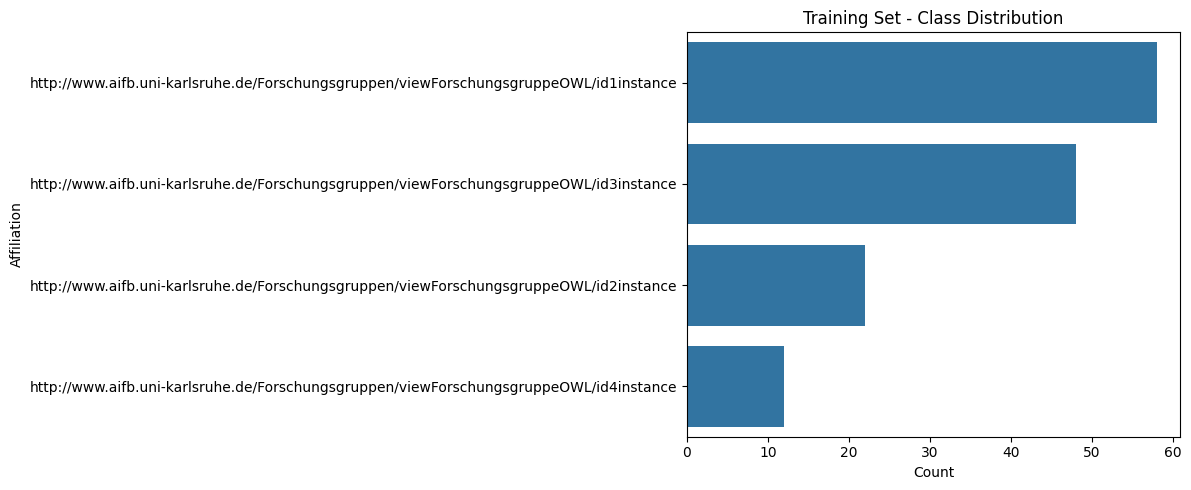

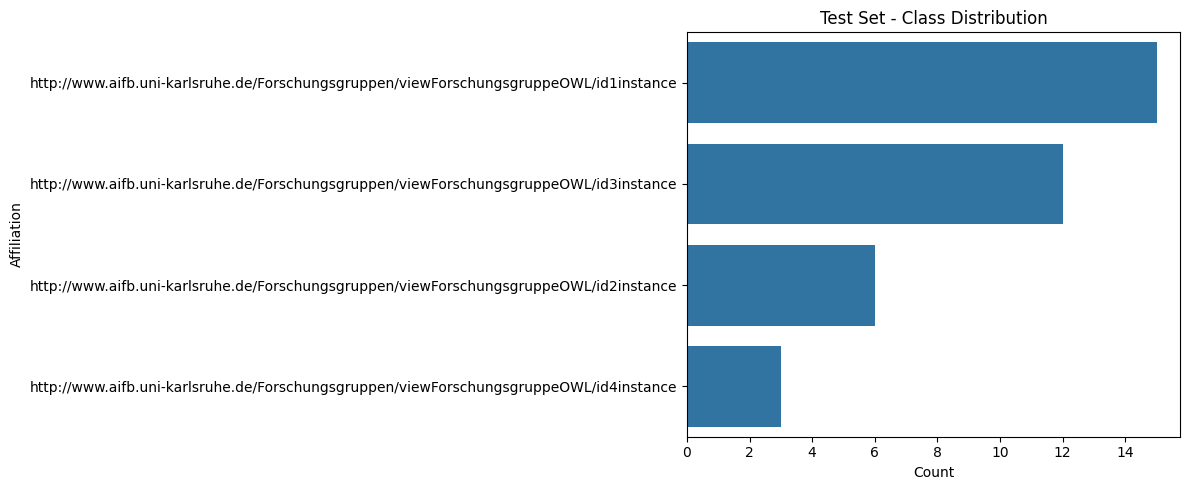

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert encoded labels back to readable
y_train_labels = encoder.inverse_transform(y_train_enc)
y_test_labels = encoder.inverse_transform(y_test_enc)

# Plot train and test distribution
plt.figure(figsize=(12, 5))
sns.countplot(y=y_train_labels, order=pd.Series(y_train_labels).value_counts().index)
plt.title("Training Set - Class Distribution")
plt.xlabel("Count")
plt.ylabel("Affiliation")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.countplot(y=y_test_labels, order=pd.Series(y_test_labels).value_counts().index)
plt.title("Test Set - Class Distribution")
plt.xlabel("Count")
plt.ylabel("Affiliation")
plt.tight_layout()
plt.show()


# Feature importance

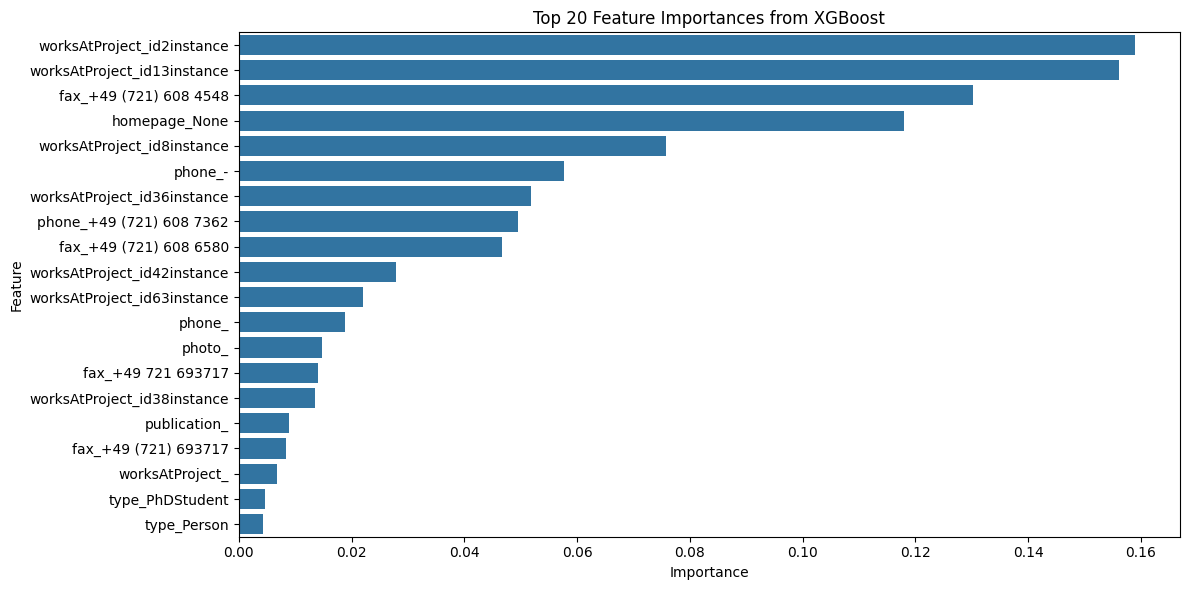

In [ ]:
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': filtered_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# top 20 features
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title("Top 20 Feature Importances from XGBoost")
plt.tight_layout()
plt.show()
